# imports

In [1]:
%env HSA_OVERRIDE_GFX_VERSION=10.3.0
import re

import pandas as pd
import numpy as np

from gensim.models import Word2Vec, KeyedVectors, FastText, fasttext


import spacy

from sklearn.preprocessing import LabelBinarizer

from unidecode import unidecode
import unicodedata as ud
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

from sklearn.model_selection import KFold

from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import torch
import torch.nn as nn 

from sklearn.metrics import f1_score

import random

from sklearn.manifold import TSNE

import optuna

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc

# variable to control if we want to use the Optuna Framework
# change it to True if you want to use it
use_optuna = False

# variable to control if we want to use t-sne to visualize the embeddings
# change it to True if you want to use it
tnse = False

# variable to control if we want to use the K-Fold Cross Validation
# change it to True if you want to use it
kfold = False

# variable to control if we want to run the brute force approach
# change it to True if you want to use it
use_brute_force = False

env: HSA_OVERRIDE_GFX_VERSION=10.3.0


# Set seed and choose device

In [2]:
def set_seed(seed = 1234):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# set seed
set_seed()

#choose device to train the model
compute_unit = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load our model

In [3]:
Word2VecModel = KeyedVectors.load_word2vec_format('/kaggle/input/mymodel2/cc.el.300.vec')

# Read data

In [4]:
TrainSet = pd.read_csv('/kaggle/input/ys19-2023-assignment-3/train_set.csv')
ValidationSet = pd.read_csv('/kaggle/input/ys19-2023-assignment-3/valid_set.csv')
TestSet = pd.read_csv('/kaggle/input/ys19-2023-assignment-3/test_set.csv')

In [5]:
#drop useless columns
Xtrain = TrainSet.drop(["Sentiment", "New_ID"], axis=1)
Xval = ValidationSet.drop(["Sentiment", "New_ID"], axis=1)
Xtest = TestSet.drop(["New_ID"], axis=1)

# concat Text and Party to Text and Drop Party column
Xtrain["Text"] = Xtrain["Text"] + " " + Xtrain["Party"]
Xval["Text"] = Xval["Text"] + " " + Xval["Party"]
Xtest["Text"] = Xtest["Text"] + " " + Xtest["Party"]

Xtrain = Xtrain.drop(["Party"], axis=1)
Xval = Xval.drop(["Party"], axis=1)
Xtest = Xtest.drop(["Party"], axis=1)

#Create Ytrain and Yval
Ytrain = TrainSet[["Sentiment"]].copy()
Yval = ValidationSet[["Sentiment"]].copy()

# Copy Xtrain and Xval to new variables (helpful for Brute Force Case)
Xtrain_without_preprocess = Xtrain.copy()
Xval_without_preprocess = Xval.copy()

# Make Y one hot encoded

In [6]:
encoder = LabelBinarizer()
encoder.fit(Ytrain)
Ytrain = encoder.transform(Ytrain)
Yval = encoder.transform(Yval)

# WordCloud

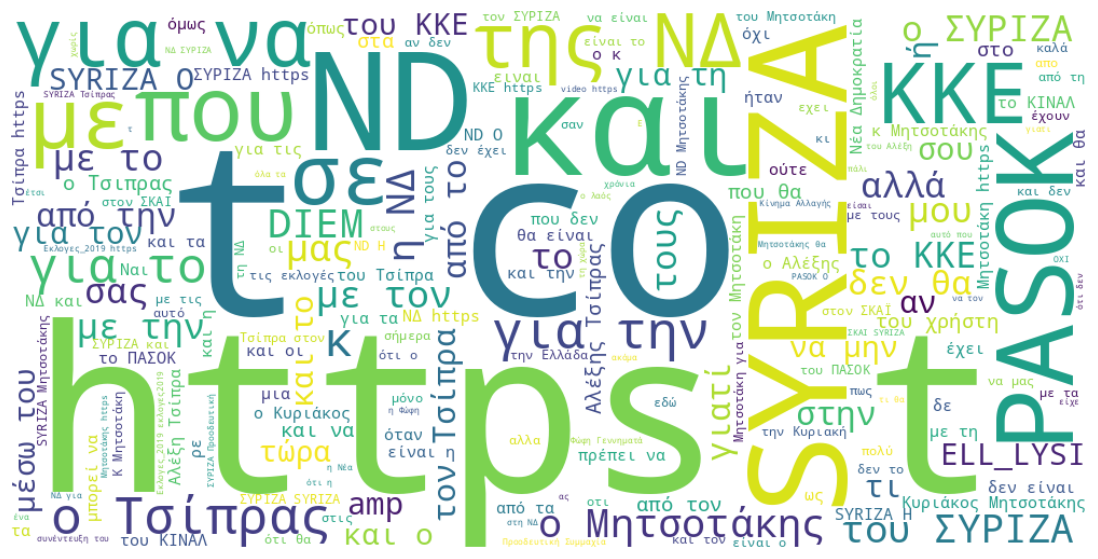

In [7]:
# Concatenate the text data from the column 'Text'
column_data = ' '.join(Xtrain['Text'])

# Create a wordcloud object before cleaning 
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(column_data)

# Plot the wordcloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Tokens Frequency Diagram

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


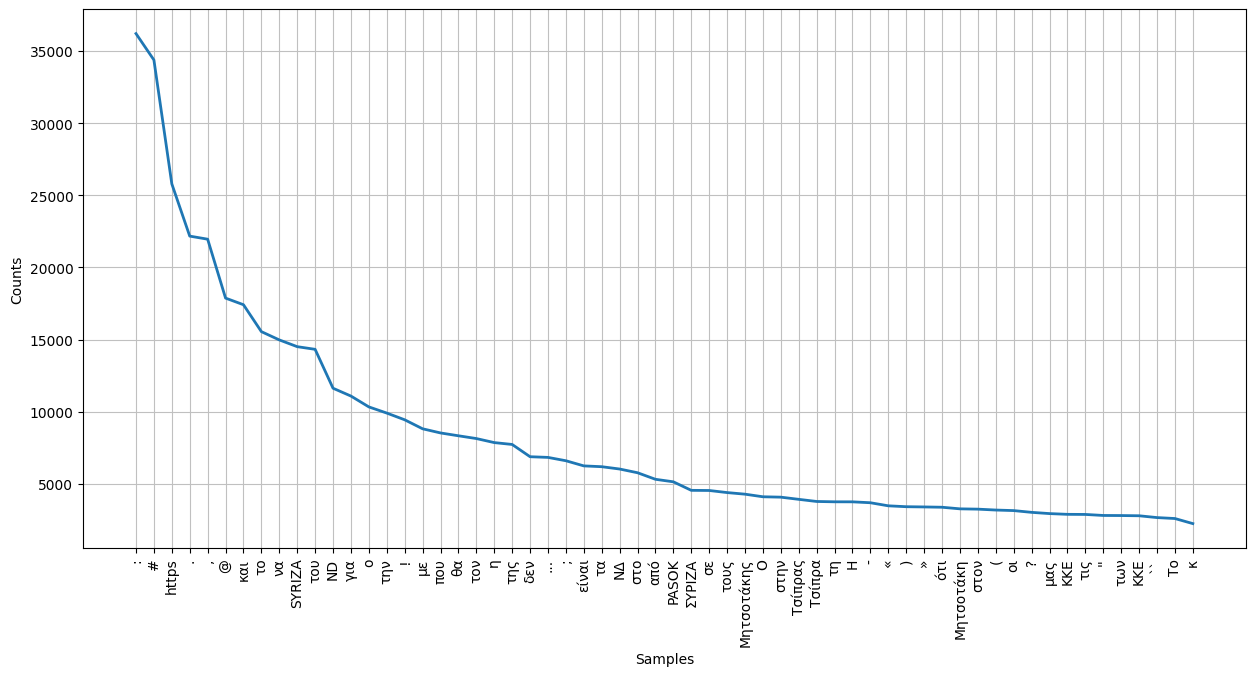

In [8]:
# Create token frequency diagram before cleaning
nltk.download('punkt')
tokens = [word_tokenize(word, language='greek') for word in Xtrain['Text']]
token_frequency = FreqDist(np.hstack(tokens))
plt.figure(figsize=(15,7))
token_frequency.plot(60, cumulative=False)

# Pre-Processing

In [9]:
# Data Preprocessing
!python -m spacy download el_core_news_lg
nlp = spacy.load("el_core_news_lg")

# remove accents
def remove_accent(text):
    d= {ord('\N{COMBINING ACUTE ACCENT}'):None}
    X_without_accents=ud.normalize('NFD',text).translate(d)
    return X_without_accents

def process_tweet(tweet):
    doc = nlp(tweet)
    tweet = ""
    for token in doc:
        if not token.is_stop and not token.is_punct and not token.is_space and not token.like_url and len(token.lemma_)>1 and len(token)<15 and not token.pos_ == 'VERB':
            tweet += token.lemma_ + " "
    return tweet
           
#remove emojis
def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', string) 


# remove emojis
Xtrain['Text'] = Xtrain['Text'].map(remove_emoji)
Xval['Text'] = Xval['Text'].map(remove_emoji)
Xtest['Text'] = Xtest['Text'].map(remove_emoji)

# remove stop words, punctuation, spaces, urls and lemmatize
Xtrain['Text'] = Xtrain['Text'].map(process_tweet)
Xval['Text'] = Xval['Text'].map(process_tweet)
Xtest['Text'] = Xtest['Text'].map(process_tweet)

# remove mentions
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'@\S+', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'@\S+', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'@\S+', '', x))

# remove accents
Xtrain['Text'] = Xtrain['Text'].map(remove_accent)
Xval['Text'] = Xval['Text'].map(remove_accent)
Xtest['Text'] = Xtest['Text'].map(remove_accent)

# remove numbers
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'\d+', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'\d+', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'\d+', '', x))

# remove & symbols
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'%', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'%', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'%', '', x))

# remove dots and commas
Xtrain['Text'] = Xtrain['Text'].map(lambda x: re.sub(r'[.,]', '', x))
Xval['Text'] = Xval['Text'].map(lambda x: re.sub(r'[.,]', '', x))
Xtest['Text'] = Xtest['Text'].map(lambda x: re.sub(r'[.,]', '', x))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.6/568.6 MB 2.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_lg')


# WordCloud

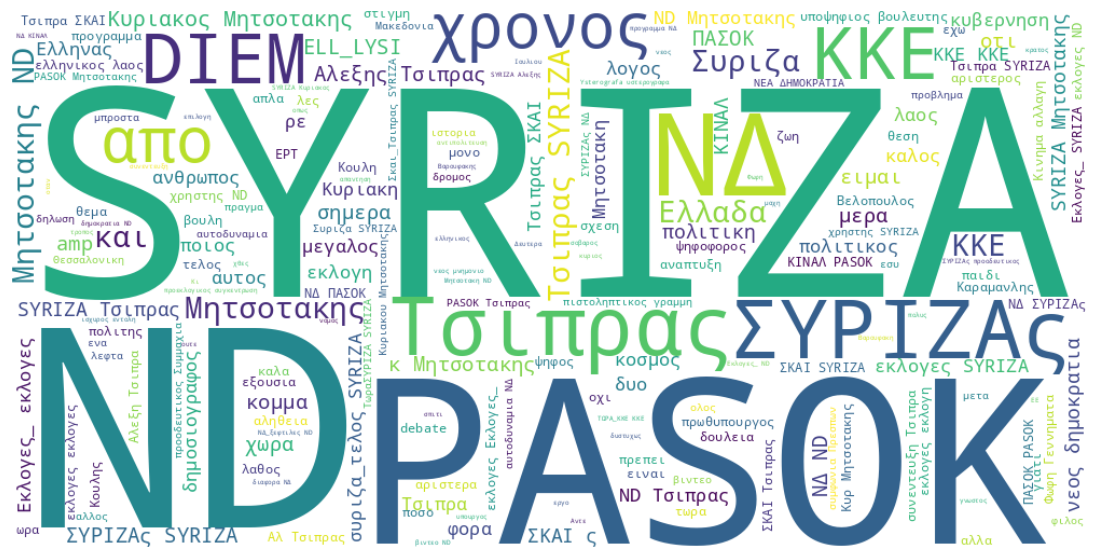

In [10]:
# Concatenate the text data from the column 'Text'
column_data = ' '.join(Xtrain['Text'])

# Create a wordcloud object after cleaning 
wordcloud = WordCloud(width = 1000, height = 500, background_color='white').generate(column_data)

# Plot the wordcloud
plt.figure(figsize=(15,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Tokens Frequency Diagram

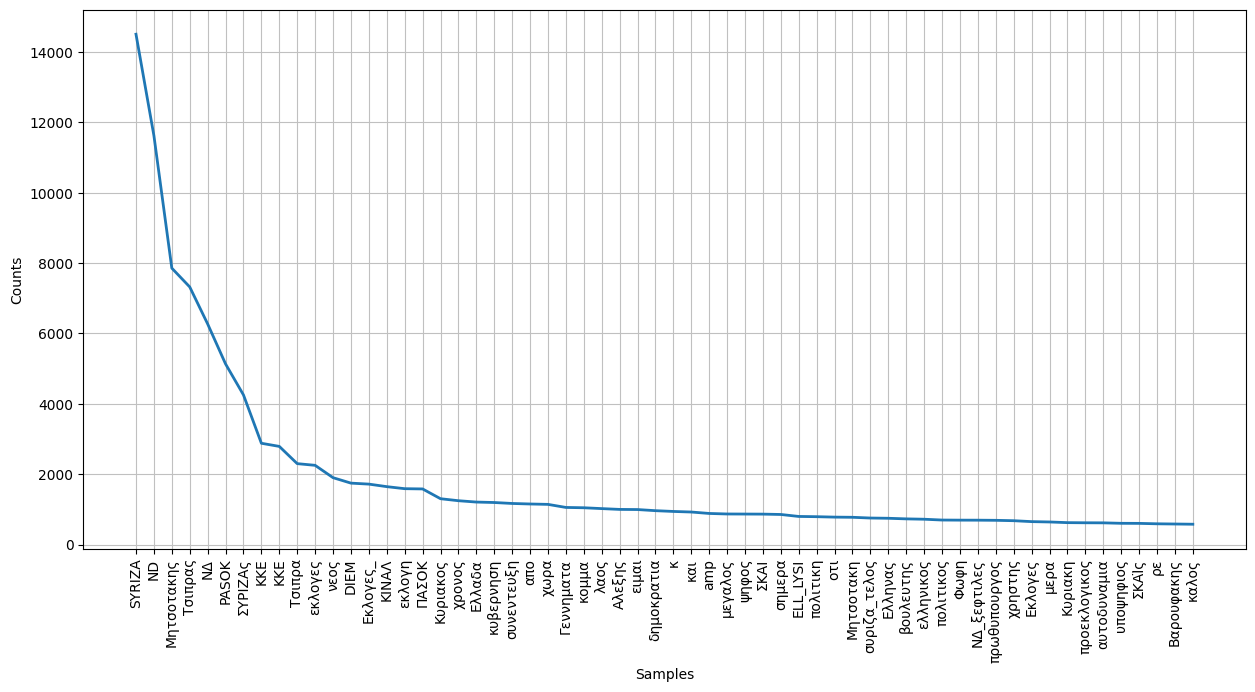

In [11]:
# Create token frequency diagram after cleaning
tokens = [word_tokenize(word, language='greek') for word in Xtrain['Text']]
token_frequency = FreqDist(np.hstack(tokens))
plt.figure(figsize=(15,7))
token_frequency.plot(60, cumulative=False)

# TSNE Visualization

In [12]:
def tnse_visualization(XVectorized,labels):
    #visualize with t-sne
    tsne = TSNE(n_components=2, random_state=0)
    XVectorized = tsne.fit_transform(XVectorized)

    x = []
    y = []
    for value in XVectorized:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(10,10)) 
    plt.title('T-SNE Visualization')
    for i in range(50):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                        xy=(x[i], y[i]),
                        xytext=(2, 2),
                        textcoords='offset points',
                        ha='right',
                        va='bottom')
    plt.show()

# Vectorization

In [13]:
#each tweet is a vector occurs from the mean of the vectors of the words that compose it
def convert_tweet_to_vector(tweet):
    vector = np.zeros(Word2VecModel.vector_size)
    number = 0
    words = tweet.split()

    for word in words:
        try:
            vector = vector + Word2VecModel.get_vector(word)
            number = number + 1
        except:
            pass
        
    if(number != 0):
        vector /= number 
        
    
    return vector 



# convert tweets to vectors
XtrainVectorized = Xtrain['Text'].map(convert_tweet_to_vector)
XtrainVectorized = np.array(XtrainVectorized.tolist())

labels = []
#i want to give to each training sentence a name
for i in range(len(XtrainVectorized)):
    label = "sentence" + str(i)
    labels.append(label)
    
# visualize with t-sne
if tnse == True:
    tnse_visualization(XtrainVectorized,labels)


XvalVectorized = Xval['Text'].map(convert_tweet_to_vector)
XvalVectorized = np.array(XvalVectorized.tolist())

# convert tweets to vectors (without having been preprocessed)
XtrainVectorized_without_preprocess = Xtrain_without_preprocess['Text'].map(convert_tweet_to_vector)
XtrainVectorized_without_preprocess = np.array(XtrainVectorized_without_preprocess.tolist())

XvalVectorized_without_preprocess = Xval_without_preprocess['Text'].map(convert_tweet_to_vector)
XvalVectorized_without_preprocess = np.array(XvalVectorized_without_preprocess.tolist())

# Save to tensors

In [14]:
def Save_to_tensors(XtrainVectorized, Ytrain, XvalVectorized, Yval, compute_unit):

    XtrainTensor = torch.tensor(XtrainVectorized, dtype=torch.float, device=compute_unit)
    YtrainTensor = torch.tensor(Ytrain, dtype=torch.float, device=compute_unit)

    XvalTensor = torch.tensor(XvalVectorized, dtype=torch.float, device=compute_unit)
    YvalTensor = torch.tensor(Yval, dtype=torch.float, device=compute_unit)
    
    return XtrainTensor, YtrainTensor, XvalTensor, YvalTensor

#save to tensors
XtrainTensor, YtrainTensor, XvalTensor, YvalTensor = Save_to_tensors(XtrainVectorized, Ytrain, XvalVectorized, Yval, compute_unit)
XtrainTensor_without_preprocess, YtrainTensor, XvalTensor_without_preprocess, YvalTensor = Save_to_tensors(XtrainVectorized_without_preprocess, Ytrain, XvalVectorized_without_preprocess, Yval, compute_unit)

# Basic Neural Network

In [15]:
class RNN(nn.Module):
    def __init__(self, cell_type, input_size, hidden_size, output_size, timesteps, brute_force = False, dropout = 0, num_layers = 1):
        super(RNN, self).__init__()

        cells = {
            "RNN": nn.RNN,
            "LSTM": nn.LSTM,
            "GRU": nn.GRU
        }

        self.cell_type = cell_type
        self.dropout = nn.Dropout(p=dropout)
        self.brute_force = brute_force

        self.rnn = cells[cell_type](
            input_size=input_size,
            hidden_size=hidden_size,
            batch_first=True,
            dropout=dropout,
            num_layers=num_layers,
            bidirectional=True
        )

        if self.brute_force:
            self.out = nn.Linear(2 * hidden_size, output_size)
        else:
            self.out = nn.Linear(2 * hidden_size * timesteps, output_size)


    def forward(self, x):
        # Pass through the RNN layer
        if self.cell_type == 'LSTM':
            r_out, (h_n, h_c) = self.rnn(x)
        else:
            r_out, h_n = self.rnn(x)

        # Apply dropout to the output of the RNN layer
        r_out = self.dropout(r_out)

        if self.brute_force:
            # use the information of the last timestep
            out = self.out(r_out[:, -1, :])
        else:
            # Use the information of all the timesteps
            r_out = r_out.reshape(r_out.shape[0],-1)
            out = self.out(r_out)

        return out

# Skip Connection Neural Network

In [16]:
class RNN_Skip_Connections(nn.Module):
    def __init__(self, hidden_size, input, output, timesteps, type = 'LSTM', num_layers = 1, dropout = 0):
        super(RNN_Skip_Connections, self).__init__()

        self.type = type
        self.input = input
        self.out = nn.Linear(2 * hidden_size * timesteps, output)
        self.dropout = nn.Dropout(p=dropout)
        self.num_layers = num_layers
        self.rnn_layers = nn.ModuleList()

        if type == 'RNN':
            cell = nn.RNN
        elif type == 'LSTM':
            cell = nn.LSTM
        elif type == 'GRU':
            cell = nn.GRU

        # Create the layers
        for i in range(self.num_layers):
            if i == 0:
                self.rnn_layers.append(cell(input_size = input, hidden_size = hidden_size, batch_first = True, num_layers = 1, bidirectional = True))   
            elif i == 1:
                self.rnn_layers.append(cell(input_size = 2 * hidden_size, hidden_size = hidden_size, batch_first = True, num_layers = 1, bidirectional = True))   
            else:
                self.rnn_layers.append(cell(input_size = 4 * hidden_size, hidden_size = hidden_size, batch_first = True, num_layers = 1, bidirectional = True))

    def forward(self, input):
        output = None
        last_output = None
        # Pass through the RNN layers and take into account as input the two previous output layers
        for i, layer in enumerate(self.rnn_layers):
            last_output = output
            output, _ = layer(input)

            if i < 1:
                input = output
            else:
                input = torch.cat((output,last_output),dim=2)
        
        # Use the information of all the timesteps
        output = self.dropout(output)
        output = output.reshape(output.shape[0], -1) 
        output = self.out(output)
        
        return output

# Training

In [17]:
def plot_roc_curve_confusion_matrix(neural_network_model, XvalTensor, Yval, attention = False):  
    
    with torch.no_grad():
        # predict the whole validation set
        neural_network_model.eval()
        if attention == False:
            Xval_reshaped = XvalTensor.view(-1,300,1)
            Yval_predict = neural_network_model(Xval_reshaped)
        else: 
            Yval_predict = neural_network_model(XvalTensor)

    # ROC Curves
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(Yval.shape[1]):
        fpr[i], tpr[i], _ = roc_curve(Yval[:, i], Yval_predict[:, i].cpu().numpy())
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curves
    class_of_interest = ["POSITIVE", "NEGATIVE", "NEUTRAL"]
    plt.figure(figsize=(8, 6))
    
    for i in range(Yval.shape[1]):
        plt.plot(fpr[i], tpr[i], label=f'{class_of_interest[i]} (AUC = {roc_auc[i]:.2f})')


    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc="lower right")
    plt.show()
    
    # Confusion Matrices 
    # we convert them to their original form
    Yval_init = encoder.inverse_transform(Yval)
    
    Yval_predict = torch.argmax(Yval_predict, axis=1)
    Ypred_init = np.zeros(shape=(Yval_predict.shape[0],3))
    Ypred_init[np.arange(len(Yval_predict.cpu())), Yval_predict.cpu()] = 1
    Ypred_init = encoder.inverse_transform(Ypred_init)

    ConfusionMatrixDisplay.from_predictions(Yval_init, Ypred_init, normalize="true",cmap=plt.cm.YlOrRd)
    plt.show()

In [18]:
def plot_learning_curves(list_of_train_losses, list_of_valid_losses, list_of_f1_scores_train, list_of_f1_scores_valid, epoch_size_list):   
    plt.plot(epoch_size_list, list_of_f1_scores_train)
    plt.plot(epoch_size_list, list_of_f1_scores_valid)
    plt.xlabel("Epochs")
    plt.ylabel("F1 scores",fontweight='bold')
    plt.ylim(ymin=0.0, ymax=1.0)
    plt.legend(["Train", "Valid"])
    plt.show()

    # plot validation and training loss
    plt.plot(epoch_size_list, list_of_train_losses)
    plt.plot(epoch_size_list, list_of_valid_losses)
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.legend(["Train", "Valid"])
    plt.show()

In [19]:
def model_train(TrainDataloader, ValDataloader, neural_network_model, loss_func, optimizer, compute_unit, timesteps, epochs = 50, gradient_clipping = False, clip_value=1.0, attention = False):
    list_of_f1_scores_train = []
    list_of_f1_scores_valid = []

    list_of_train_losses = []
    list_of_valid_losses = []

    for epoch in range(epochs):
        neural_network_model.train()
        
        TrainBatchLosses = []
        ValBatchLosses = []

        ValPredictions = []
        ValTrueLabels = []

        TrainPredictions = []
        TrainTrueLabels = []

        # Training phase
        for XtrainBatch, YtrainBatch in TrainDataloader:
            
            XtrainBatch = XtrainBatch.to(compute_unit)
            YtrainBatch = YtrainBatch.to(compute_unit)
            
            if attention == False:
                b_XtrainBatch = XtrainBatch.view(-1,timesteps,1)
            else:
                b_XtrainBatch = XtrainBatch
            
            # predict each XtrainBatch
            YtrainPred = neural_network_model(b_XtrainBatch)
            TrainLoss = loss_func(YtrainPred, YtrainBatch)
        
            TrainLoss.backward()

            if gradient_clipping == True:
                torch.nn.utils.clip_grad_norm_(neural_network_model.parameters(), clip_value)

            optimizer.step()
            optimizer.zero_grad()

            TrainBatchLosses.append(TrainLoss.item())

            YtrainPred = YtrainPred.cpu()
            YtrainBatch = YtrainBatch.cpu()
            
            # Total Training Predictions and True Labels every epoch
            TrainPredictions.extend(YtrainPred.argmax(axis=1).tolist())
            TrainTrueLabels.extend(YtrainBatch.argmax(axis=1).tolist())
            
        
        # Validation phase
        with torch.no_grad():
            
            neural_network_model.eval()
            
            for XvalBatch, YvalBatch in ValDataloader:
                
                XvalBatch = XvalBatch.to(compute_unit)
                YvalBatch = YvalBatch.to(compute_unit)

                if attention == False:
                    b_XvalBatch = XvalBatch.view(-1,timesteps,1)
                else:
                    b_XvalBatch = XvalBatch
                
                # predict each XvalBatch              
                YvalPred = neural_network_model(b_XvalBatch)
                
                ValLoss = loss_func(YvalPred, YvalBatch)
                ValBatchLosses.append(ValLoss.item())
                
                YvalPred = YvalPred.cpu()
                YvalBatch = YvalBatch.cpu()
                
                # Total Validation Predictions and True Labels every epoch
                ValPredictions.extend(YvalPred.argmax(axis=1).tolist())
                ValTrueLabels.extend(YvalBatch.argmax(axis=1).tolist())
            
        
        #calculate f1 score for each epoch
        f1_train = f1_score(TrainTrueLabels,TrainPredictions, average='micro')
        f1_valid = f1_score(ValTrueLabels,ValPredictions, average='micro')
        
        # keep the F1 scores and the losses of every epoch in a list       
        list_of_f1_scores_train.append(f1_train)
        list_of_f1_scores_valid.append(f1_valid)
        
        list_of_train_losses.append(np.mean(TrainBatchLosses))
        list_of_valid_losses.append(np.mean(ValBatchLosses))
        
        
        print("Epoch: ", epoch + 1, " Train Loss: ", np.mean(TrainBatchLosses), " Validation Loss: ", np.mean(ValBatchLosses), " Train F1: ", f1_train, " Validation F1: ", f1_valid)

            
    #plot f1 and loss learning curves
    plot_learning_curves(list_of_train_losses, list_of_valid_losses, list_of_f1_scores_train, list_of_f1_scores_valid, range(1,epochs+1))

    return f1_valid,list_of_f1_scores_train,list_of_f1_scores_valid,list_of_train_losses,list_of_valid_losses



# Brute Force Attempt

In [20]:
# Here is the Brute Force Case. We have:
# 1. The data hasn't been preprocessed
# 2. The The batch size is 64
# 3. The learning rate is 0.01
# 4. The hidden size is 8
# 5. The cell type is RNN
# Turn the use_brute_force variable to True if you want to run the brute force case

if (use_brute_force == True):
    # initialize the model
    hidden_size = 8
    output_size = YtrainTensor.shape[1]
    timesteps = 300
    cell_type = 'RNN'
    input_size = 1
    batch_size = 64

    net = RNN(cell_type, input_size, hidden_size, output_size, timesteps, brute_force = True).to(compute_unit)

    LR = 0.01
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)
    loss_func = nn.CrossEntropyLoss()

    #Initialize datasets and dataloaders
    TrainDataset = torch.utils.data.TensorDataset(XtrainTensor_without_preprocess, YtrainTensor) 
    TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size = batch_size, shuffle=True) 

    ValDataset = torch.utils.data.TensorDataset(XvalTensor_without_preprocess, YvalTensor) 
    ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size = batch_size, shuffle=True) 

    # Train the model
    epochs = 50
    _ = model_train(TrainDataloader, ValDataloader, net, loss_func, optimizer, compute_unit, timesteps, epochs)

# LSTM and GRU Architectures

Epoch:  1  Train Loss:  1.165514886379242  Validation Loss:  1.1198888222376506  Train F1:  0.332978432978433  Validation F1:  0.3333333333333333
Epoch:  2  Train Loss:  1.1095403697755601  Validation Loss:  1.1051972309748332  Train F1:  0.3316953316953317  Validation F1:  0.3333333333333333
Epoch:  3  Train Loss:  1.1008241706424289  Validation Loss:  1.100740909576416  Train F1:  0.33434343434343433  Validation F1:  0.3331422018348624
Epoch:  4  Train Loss:  1.0998372766706679  Validation Loss:  1.1013060808181763  Train F1:  0.3385203385203385  Validation F1:  0.3333333333333333
Epoch:  5  Train Loss:  1.1001633538140192  Validation Loss:  1.1005420684814453  Train F1:  0.33677313677313675  Validation F1:  0.3331422018348624
Epoch:  6  Train Loss:  1.0989586975839403  Validation Loss:  1.0981977383295696  Train F1:  0.3361179361179361  Validation F1:  0.3486238532110092
Epoch:  7  Train Loss:  1.0986761185857985  Validation Loss:  1.0984054803848267  Train F1:  0.33914823914823916 

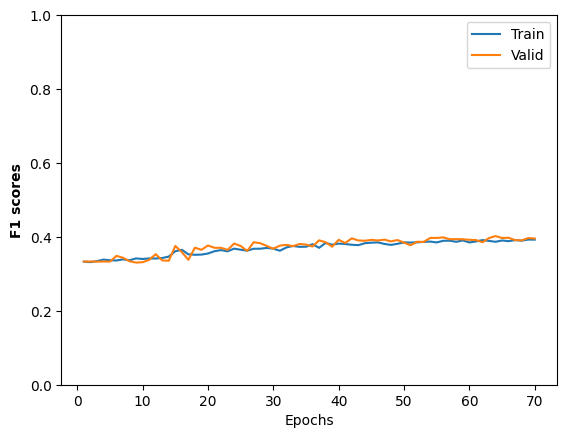

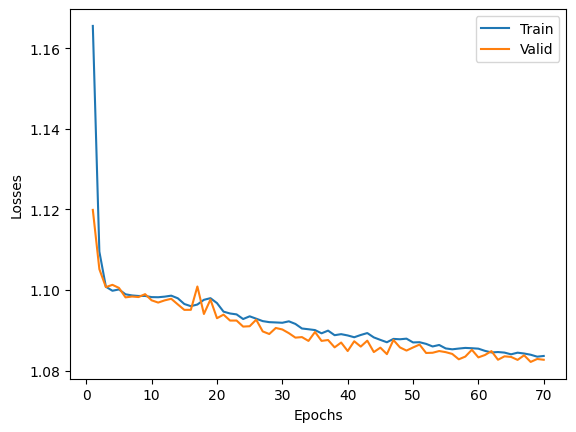

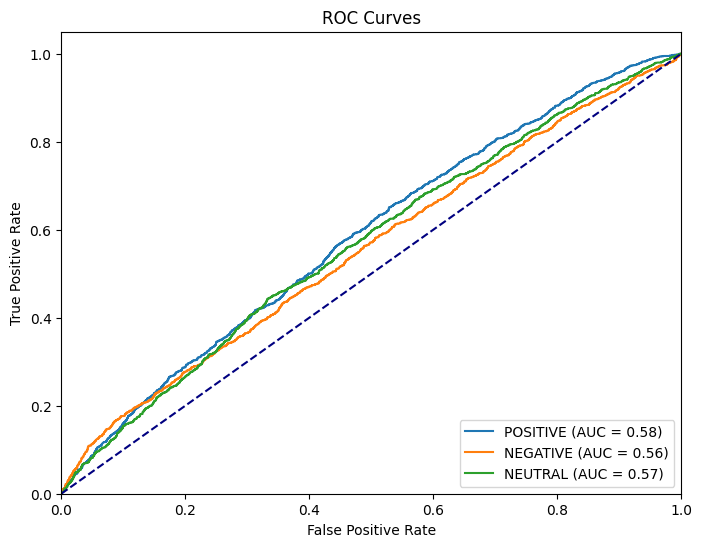

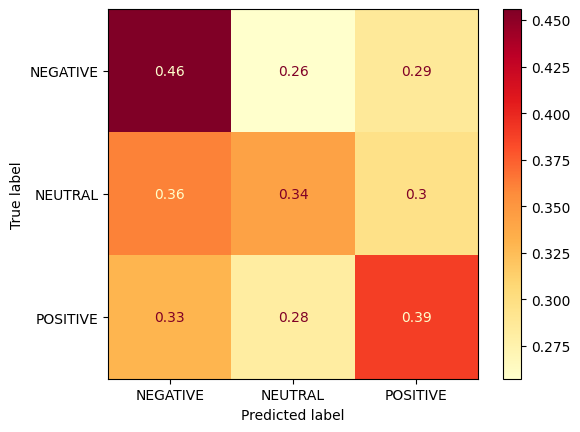

In [21]:
# Now we will try to use LSTM and GRU cells for batch size 2048, hidden size 8 and learning rate 0.001
# We will use the variable LSTM_GRU to control the cell type
# LSTM_GRU = 0 -> LSTM
# LSTM_GRU = 1 -> GRU

LSTM_GRU = 1

# initialize the model
hidden_size = 8
output_size = YtrainTensor.shape[1]

if LSTM_GRU == 0:
    cell_type = 'LSTM'
elif LSTM_GRU == 1:
    cell_type = 'GRU'

input_size = 1
batch_size = 2048
timesteps = 300

net = RNN(cell_type = cell_type, input_size = input_size, hidden_size = hidden_size, output_size = output_size, timesteps = timesteps).to(compute_unit)

LR = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

#Initialize datasets and dataloaders
TrainDataset = torch.utils.data.TensorDataset(XtrainTensor, YtrainTensor) 
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size = batch_size, shuffle=True) 

ValDataset = torch.utils.data.TensorDataset(XvalTensor, YvalTensor) 
ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size = batch_size, shuffle=True) 

# Train the model
epochs = 70
_ = model_train(TrainDataloader, ValDataloader, net, loss_func, optimizer, compute_unit, timesteps, epochs)

# plot the ROC curve and the confusion matrix
plot_roc_curve_confusion_matrix(net,XvalTensor,Yval)

# 2 RNN Layers with Dropout Rate and Gradient Clipping

Epoch:  1  Train Loss:  1.1483845048480563  Validation Loss:  1.1091614564259846  Train F1:  0.32814632814632816  Validation F1:  0.3333333333333333
Epoch:  2  Train Loss:  1.101725545194414  Validation Loss:  1.1006316343943279  Train F1:  0.3313950313950314  Validation F1:  0.3333333333333333
Epoch:  3  Train Loss:  1.0998880465825398  Validation Loss:  1.0990399916966755  Train F1:  0.33084903084903083  Validation F1:  0.3333333333333333
Epoch:  4  Train Loss:  1.099083767996894  Validation Loss:  1.0992906888326008  Train F1:  0.33475293475293477  Validation F1:  0.3333333333333333
Epoch:  5  Train Loss:  1.0992317530843947  Validation Loss:  1.0987948179244995  Train F1:  0.33516243516243516  Validation F1:  0.3331422018348624
Epoch:  6  Train Loss:  1.098490125603146  Validation Loss:  1.0984694957733154  Train F1:  0.3394758394758395  Validation F1:  0.3333333333333333
Epoch:  7  Train Loss:  1.0982369184494019  Validation Loss:  1.0978457927703857  Train F1:  0.346956046956047 

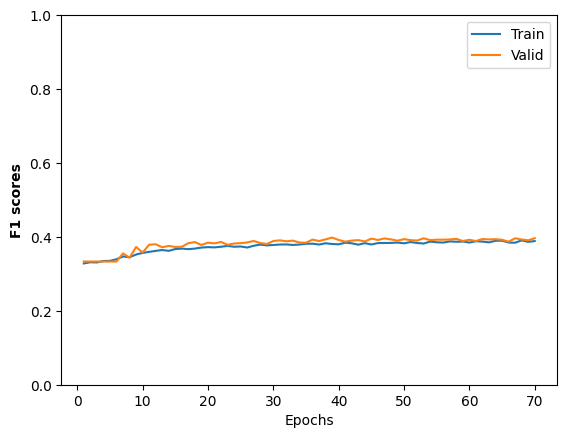

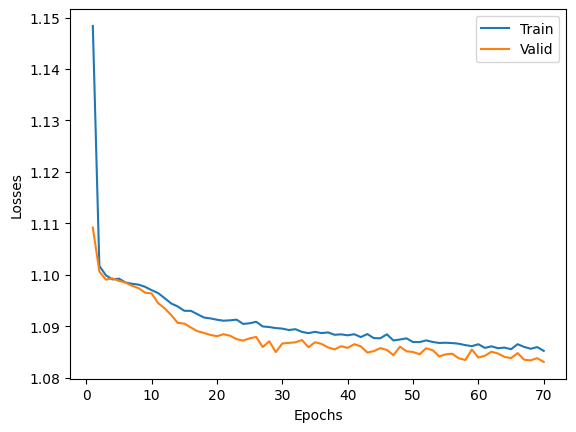

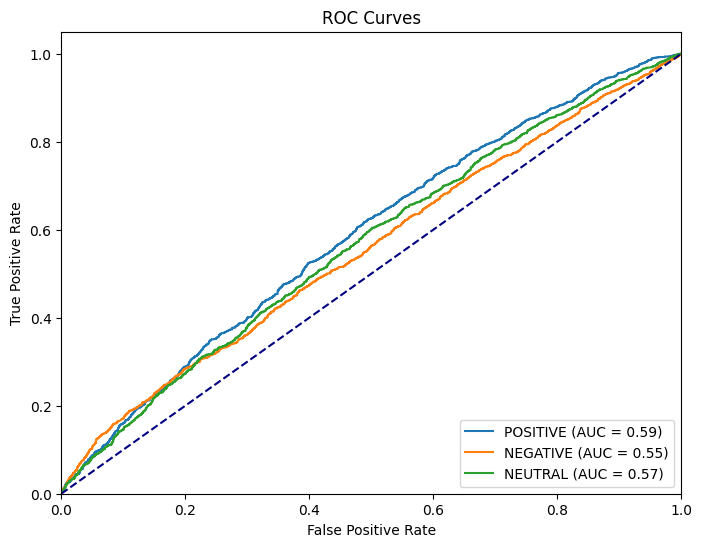

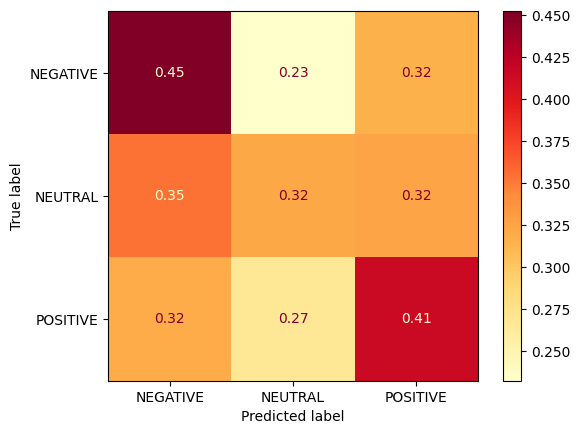

In [22]:
# As mentioned on the report the hidden size, which is used in my final model is 16.
# Further exploration with larger hidden sizes is not deemed necessary for presentation here.
# Subsequent experiments will utilize a hidden size of 16.
# Now we will try to add more RNN layers and use dropout regularization and the gradient clipping technique. 
# Here is a case with 2 layers, dropout rate 0.3 and clip value 0.4

# initialize the model
hidden_size = 16
output_size = YtrainTensor.shape[1]
num_layers = 2
dropout = 0.3
gradient_clipping = True
clip_value = 0.4
cell_type = 'LSTM'
batch_size = 2048
timesteps = 300

net = RNN(cell_type = cell_type, input_size = 1, hidden_size = hidden_size, output_size = output_size, timesteps = timesteps, dropout = dropout, num_layers = num_layers).to(compute_unit)

LR = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

#Initialize datasets and dataloaders
TrainDataset = torch.utils.data.TensorDataset(XtrainTensor, YtrainTensor) 
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size = batch_size, shuffle=True) 

ValDataset = torch.utils.data.TensorDataset(XvalTensor, YvalTensor) 
ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size = batch_size, shuffle=True) 

# Train the model
epochs = 70
_ = model_train(TrainDataloader, ValDataloader, net, loss_func, optimizer, compute_unit, timesteps, epochs, gradient_clipping, clip_value)

# plot the ROC curve and the confusion matrix
plot_roc_curve_confusion_matrix(net,XvalTensor,Yval)

# Skip Connections Attempt

Epoch:  1  Train Loss:  1.1814751492606268  Validation Loss:  1.1325217485427856  Train F1:  0.32768222768222766  Validation F1:  0.3333333333333333
Epoch:  2  Train Loss:  1.1072641213734944  Validation Loss:  1.1039359172185261  Train F1:  0.3345891345891346  Validation F1:  0.3333333333333333
Epoch:  3  Train Loss:  1.1002674367692735  Validation Loss:  1.0997443596522014  Train F1:  0.3354081354081354  Validation F1:  0.3333333333333333
Epoch:  4  Train Loss:  1.099352651172214  Validation Loss:  1.0987482070922852  Train F1:  0.33513513513513515  Validation F1:  0.3333333333333333
Epoch:  5  Train Loss:  1.0989980565177069  Validation Loss:  1.0986402034759521  Train F1:  0.3310947310947311  Validation F1:  0.3555045871559633
Epoch:  6  Train Loss:  1.0989597572220697  Validation Loss:  1.0996143420537312  Train F1:  0.33636363636363636  Validation F1:  0.3333333333333333
Epoch:  7  Train Loss:  1.0993419620725844  Validation Loss:  1.0986836353937786  Train F1:  0.332214032214032

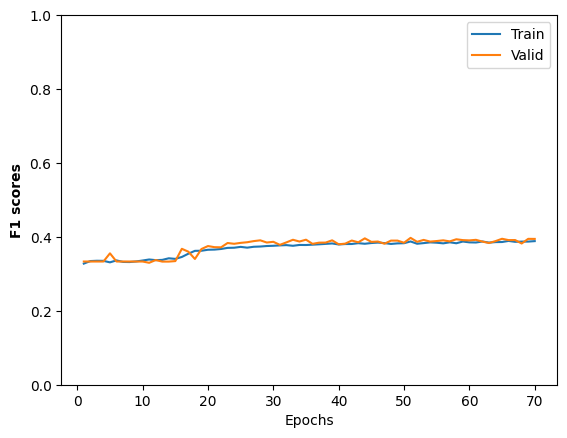

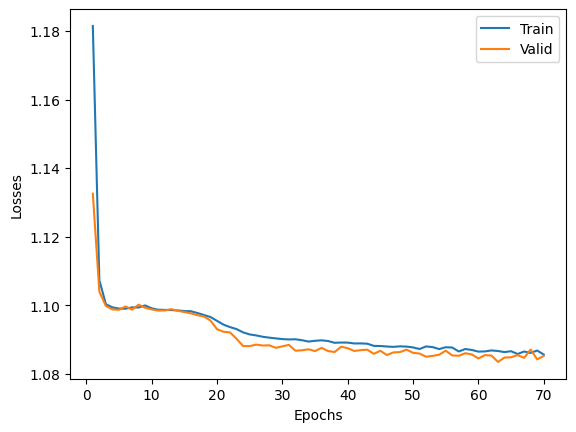

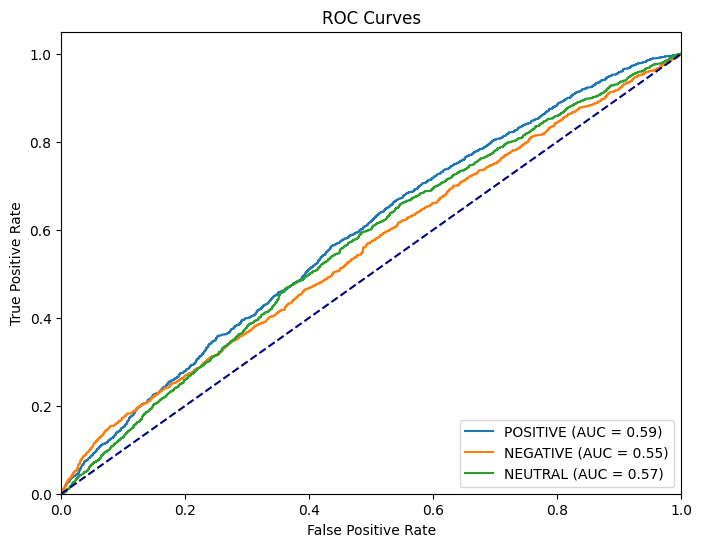

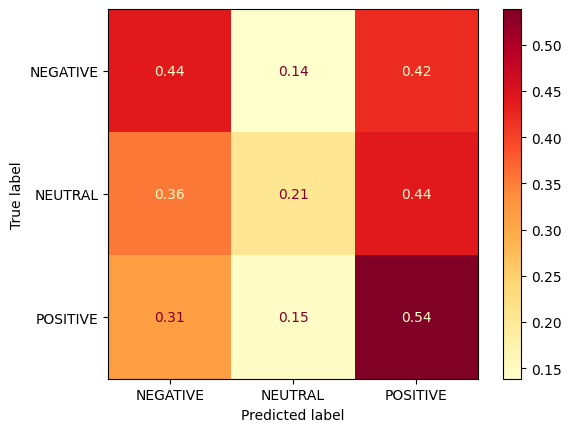

In [23]:
# Here we will use the Skip Connections method in our attempt to avoid the vanishing gradient problem.
# We will use the LSTM cell and 3 layers. We will also use a dropout rate of 0.3.
# During experimentation phase, I tried more layers, but for time reasons I will present the case with 3 layers here.
# initialize the model
hidden_size = 16
output_size = YtrainTensor.shape[1]
cell_type = 'LSTM'
batch_size = 2048
timesteps = 300
num_layers = 3
input_size = 1
dropout = 0.3

net = RNN_Skip_Connections(hidden_size, 1, output_size, timesteps, type = cell_type, num_layers = num_layers, dropout = dropout).to(compute_unit)

LR = 0.001
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

#Initialise datasets and dataloaders
TrainDataset = torch.utils.data.TensorDataset(XtrainTensor, YtrainTensor) 
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size = batch_size, shuffle=True) 

ValDataset = torch.utils.data.TensorDataset(XvalTensor, YvalTensor) 
ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size = batch_size, shuffle=True) 

# Train the model
epochs = 70
_ = model_train(TrainDataloader, ValDataloader, net, loss_func, optimizer, compute_unit, timesteps, epochs)

# plot the ROC curve and the confusion matrix
plot_roc_curve_confusion_matrix(net,XvalTensor,Yval)

# K Fold Cross Validation

In [24]:
# We use Kfold cross validation in order to get a more robust estimation of the neural network's performance.
#change the kfold variable to True if you want to use it
if kfold == True:
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    VectorizedDataset = np.concatenate((XtrainVectorized, XvalVectorized), axis=0)
    whole_Y = np.concatenate((Ytrain, Yval), axis=0)

    average_f1_train_scores = []
    average_f1_val_scores = []
    average_train_losses = []
    average_val_losses = []

    hidden_size = 16
    output_size = YtrainTensor.shape[1]
    cell_type = 'LSTM'
    num_layers = 1
    dropout = 0
    batch_size = 2048
    timesteps = 300


    for fold,(train_idx,test_idx) in enumerate(kfold.split(VectorizedDataset)):
        print('------------fold no---------{}----------------------'.format(fold))
        net = RNN(cell_type = cell_type, input_size = 1, hidden_size = hidden_size, output_size = output_size, timesteps = timesteps, dropout = dropout, num_layers = num_layers).to(compute_unit)

        LR = 0.001
        optimizer = torch.optim.Adam(net.parameters(), lr=LR)
        loss_func = nn.CrossEntropyLoss()

        # Get training and Validation Set    
        XtrainVectorized_kfold = VectorizedDataset[train_idx]
        XvalVectorized_kfold = VectorizedDataset[test_idx]
        Ytrain_kfold = whole_Y[train_idx]
        Yval_kfold = whole_Y[test_idx]
        
        #save to tensors\n",
        XtrainTensor_kfold, YtrainTensor_kfold, XvalTensor_kfold, YvalTensor_kfold = Save_to_tensors(XtrainVectorized_kfold, Ytrain_kfold, XvalVectorized_kfold, Yval_kfold, compute_unit)

        TrainDataset = torch.utils.data.TensorDataset(XtrainTensor_kfold, YtrainTensor_kfold) 
        ValDataset = torch.utils.data.TensorDataset(XvalTensor_kfold, YvalTensor_kfold)
        
        trainloader = torch.utils.data.DataLoader(TrainDataset,batch_size = batch_size, shuffle=True)
        valloader = torch.utils.data.DataLoader(ValDataset,batch_size = batch_size, shuffle=True)
        
        # Train the model
        epochs = 70
        f1_valid, f1_train_scores, f1_valid_scores, train_losses, valid_losses = model_train(trainloader, valloader, net, loss_func, optimizer, compute_unit, timesteps, epochs = epochs)
        
        average_f1_train_score = np.mean(f1_train_scores)
        average_f1_val_score = np.mean(f1_valid_scores)
        average_train_loss = np.mean(train_losses)
        average_val_loss = np.mean(valid_losses)
        
        average_f1_train_scores.append(average_f1_train_score)
        average_f1_val_scores.append(average_f1_val_score)
        average_train_losses.append(average_train_loss)
        average_val_losses.append(average_val_loss)
        
        
    # Plot Losses
    plt.plot(average_train_losses, label="Train Loss")
    plt.plot(average_val_losses, label="Val Loss")
    plt.xlabel("Folds")
    plt.ylabel("Loss")
    plt.legend(["Train", "Valid"])
    plt.show()

    # Plot F1 Scores
    plt.plot(average_f1_train_scores, label="Train F1 Score")
    plt.plot(average_f1_val_scores, label="Validation F1 Score")
    plt.xlabel("Folds")
    plt.ylabel("F1 Score")
    plt.ylim(ymin=0.0, ymax=1.0)
    plt.legend(["Train", "Valid"])
    plt.show()


# Optuna Framework

In [25]:
# Here is implemented the Optuna framework in order to find the best hyperparameters for batch size, dropout rate and clip value.
# Turn the use_optuna variable to True if you want to use it
trial_number = -1

def optimize_hyperparameters(trial):  
    batch_size = trial.suggest_categorical('batch_size', [256, 512, 1024, 2048,4096])
    clip_value = trial.suggest_float('clip_value', 0.1, 1.0)
    dropout = trial.suggest_float('dropout', 0.0, 0.5)
    output_size = YtrainTensor.shape[1]
    cell_type = 'LSTM'
    num_layers = 2
    timesteps = 300
    hidden_size = 16
    gradient_clipping = True

    net = RNN(cell_type = cell_type, input_size = 1, hidden_size = hidden_size, output_size = output_size, timesteps = timesteps, dropout = dropout, num_layers = num_layers).to(compute_unit)

    LR = 0.001
    optimizer = torch.optim.Adam(net.parameters(), lr=LR)
    loss_func = nn.CrossEntropyLoss()

    #Initialise datasets and dataloaders
    TrainDataset = torch.utils.data.TensorDataset(XtrainTensor, YtrainTensor) 
    TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size = batch_size, shuffle=True) 

    ValDataset = torch.utils.data.TensorDataset(XvalTensor, YvalTensor) 
    ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size = batch_size, shuffle=True) 

    epochs = 50

    f1_valid, f1_train_scores, f1_valid_scores, train_losses, valid_losses = model_train(TrainDataloader, ValDataloader, net, loss_func, optimizer, compute_unit, timesteps, epochs = epochs, gradient_clipping = gradient_clipping, clip_value = clip_value)

    return f1_valid

# use optuna framework to find the best hyperparameters for batch size, dropout rate and clip value
study = None
if use_optuna == True: 
    study = optuna.create_study(direction="maximize")
    study.optimize(optimize_hyperparameters, n_trials=50)

# Bonus: Attention Mechanism

# Vectorization

In [26]:
# We are going to use the attention mechanism to improve the performance of the model.
# The vectorization technique will be different:
# Instead of using the mean of the vectors of the words that compose the tweet, 
# we will use the vectors from all the words without averaging them.

def convert_words_to_vectors(tweet, max_length):
    words = tweet.split()
    tweet_vector = []
    for word in words:
        if word in Word2VecModel:
            tweet_vector.append(Word2VecModel[word])
    while len(tweet_vector) < max_length:
        tweet_vector.append(np.zeros(300))
    return tweet_vector[:max_length]
    

# In order to pad the tweets, we need to find the maximum length of the tweets
# We fill the tweets with zeros until they reach the maximum length
max_length = 0
for tweet in Xtrain['Text']:
    words = tweet.split()
    if len(words) > max_length:
        max_length = len(words)

for tweet in Xval['Text']:
    words = tweet.split()
    if len(words) > max_length:
        max_length = len(words)

for tweet in Xtest['Text']:
    words = tweet.split()
    if len(words) > max_length:
        max_length = len(words)
    

# convert tweets to vectors
XtrainVectorized_attention = Xtrain['Text'].tolist()
XtrainVectorized_attention = [convert_words_to_vectors(tweet, max_length) for tweet in XtrainVectorized_attention]
XtrainVectorized_attention = np.asarray(XtrainVectorized_attention)


XvalVectorized_attention = Xval['Text'].tolist()
XvalVectorized_attention = [convert_words_to_vectors(tweet, max_length) for tweet in XvalVectorized_attention]
XvalVectorized_attention = np.asarray(XvalVectorized_attention)

XtestVectorized_attention = Xtest['Text'].tolist()
XtestVectorized_attention = [convert_words_to_vectors(tweet, max_length) for tweet in XtestVectorized_attention]
XtestVectorized_attention = np.asarray(XtestVectorized_attention)

#save to tensors
XtrainTensor_attention, YtrainTensor, XvalTensor_attention, YvalTensor = Save_to_tensors(XtrainVectorized_attention, Ytrain, XvalVectorized_attention, Yval, compute_unit)
XtestTensor_attention = torch.tensor(XtestVectorized_attention, dtype=torch.float, device=compute_unit)




# Model definition

In [27]:
# Here is the Attention Mechanism, which is used by the RNN model.
class Attention(nn.Module):
    def __init__(self,  hidden_size):
        super(Attention, self).__init__()

        self.hidden_size = hidden_size

    def forward(self, rnn_output, last_hidden_state):

        # unsqueeze the final hidden state to be of the same size as the rnn outputs
        last_hidden_state = last_hidden_state.unsqueeze(2)

        # Calculate the attention weights by computing the dot product between the final hidden state and the rnn outputs
        weights = torch.bmm(rnn_output, last_hidden_state)

        # Squeeze the weights, because we don't need the third dimension
        weights = weights.squeeze(2)

        # Pass the weights through a softmax function
        weights = nn.functional.softmax(weights, dim=1)

        # Transpose the rnn outputs and unsqueeze the weights in order to be able to compute the dot product
        rnn_output = rnn_output.transpose(1, 2)
        weights = weights.unsqueeze(2)

        # Compute the context vector
        context = torch.bmm(rnn_output, weights)

        # Squeeze the context, because we don't need the third dimension
        context = context.squeeze(2)

        return context

# Here is the implementation of the RNN model with the attention mechanism.
class Rnn_with_Attention(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers = 1, layer_dimensions = [16], type = 'LSTM', dropout = 0, linear_layers = 1, skip_connection = False):
        super(Rnn_with_Attention, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        self.dropout = nn.Dropout(p=dropout)
        self.skip_connection = skip_connection

        self.type = type

        if type == 'RNN':
            cell = nn.RNN
        elif type == 'LSTM':
            cell = nn.LSTM
        elif type == 'GRU':
            cell = nn.GRU

        if skip_connection == True:
            self.rnn_layers = nn.ModuleList()

            # create the RNN layer
            for i in range(self.num_layers):
                if i == 0:
                    self.rnn_layers.append(cell(input_size = input_size, hidden_size = hidden_size, batch_first = True, num_layers = 1, bidirectional = True))   
                elif i == 1:
                    self.rnn_layers.append(cell(input_size = 2 * hidden_size, hidden_size = hidden_size, batch_first = True, num_layers = 1, bidirectional = True))   
                else:
                    self.rnn_layers.append(cell(input_size = 4 * hidden_size, hidden_size = hidden_size, batch_first = True, num_layers=  1, bidirectional = True))

        else:
            self.rnn = cell(input_size=input_size, hidden_size=hidden_size, batch_first=True, num_layers=num_layers, bidirectional = True, dropout=dropout if self.num_layers>1 else 0)


        # create fully connected layers
        self.linears = nn.ModuleList()
        dimension1 = hidden_size
        for i in range(linear_layers):
            dimension2 = layer_dimensions[i]
            if i == 0:
                linear_layer = nn.Linear(2 * dimension1, dimension2)
            else:
                linear_layer = nn.Linear(dimension1, dimension2)
            dimension1 = dimension2

            torch.nn.init.xavier_uniform_(linear_layer.weight)
            linear_layer.bias.data.zero_()
            
            self.linears.append(linear_layer)
            self.linears.append(nn.ReLU(inplace=True))
            self.linears.append(self.dropout)

        # create the output layer
        self.out = nn.Linear(dimension1, output_size)

        # create the attention mechanism
        self.attention = Attention(hidden_size)

            
    def forward(self, x):
        if self.skip_connection == True:
            output = None
            last_output = None

            for i, RNN_layer in enumerate(self.rnn_layers):
                last_output = output
                output, last_state = RNN_layer(x)

                if i < 1:
                    x = output
                else:
                    x = torch.cat((output,last_output),dim=2)  

            if self.cell_type == 'LSTM':
                last_state = last_state[0]
                
            last_hidden_state = torch.cat((last_state[0], last_state[1]), dim=1)
      
        else:
            output, hidden_state = self.rnn(x)

            # Take the last hidden state
            if self.cell_type == 'LSTM':
                last_state = hidden_state[0].view(self.num_layers, 2, x.size(0), self.hidden_size)[-1]
            else:
                last_state = hidden_state.view(self.num_layers, 2, x.size(0), self.hidden_size)[-1]
                
            # Concatenate the two directions
            last_hidden_state = torch.cat((last_state[0], last_state[1]), dim=1)
        

        # Apply attention mechanism
        x = self.attention(output, last_hidden_state)

        # Apply linear layers
        for layer in self.linears:
            x = layer(x)

        # Apply the output layer to the output
        final_out = self.out(x)

        return final_out

# Final Model

Epoch:  1  Train Loss:  1.0987605386310153  Validation Loss:  1.0986053148905437  Train F1:  0.33480753480753483  Validation F1:  0.3319954128440367
Epoch:  2  Train Loss:  1.0986891123983595  Validation Loss:  1.0985628366470337  Train F1:  0.33434343434343433  Validation F1:  0.33868501529051986
Epoch:  3  Train Loss:  1.098727696471744  Validation Loss:  1.0985465049743652  Train F1:  0.33346983346983344  Validation F1:  0.33467125382262997
Epoch:  4  Train Loss:  1.0986804101202223  Validation Loss:  1.098515550295512  Train F1:  0.33286923286923287  Validation F1:  0.3444189602446483
Epoch:  5  Train Loss:  1.0986136065589056  Validation Loss:  1.0984855095545452  Train F1:  0.3366366366366366  Validation F1:  0.35244648318042815
Epoch:  6  Train Loss:  1.0986185868581135  Validation Loss:  1.0984516541163127  Train F1:  0.3343707343707344  Validation F1:  0.3480504587155963
Epoch:  7  Train Loss:  1.09847096602122  Validation Loss:  1.0984148979187012  Train F1:  0.33568113568113

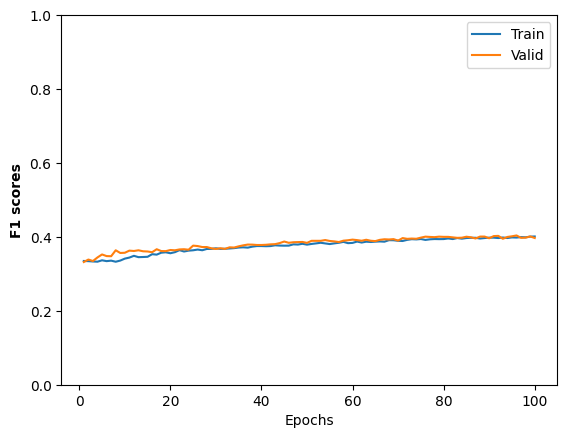

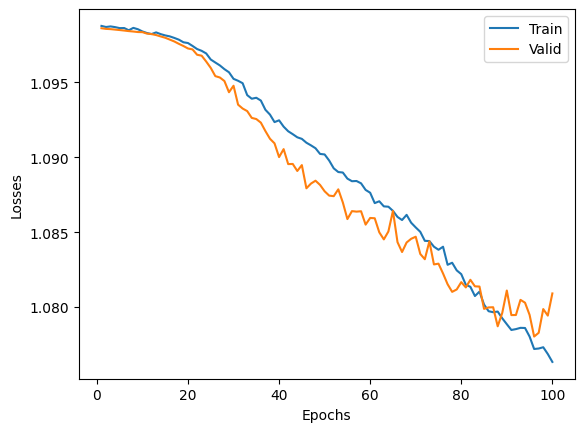

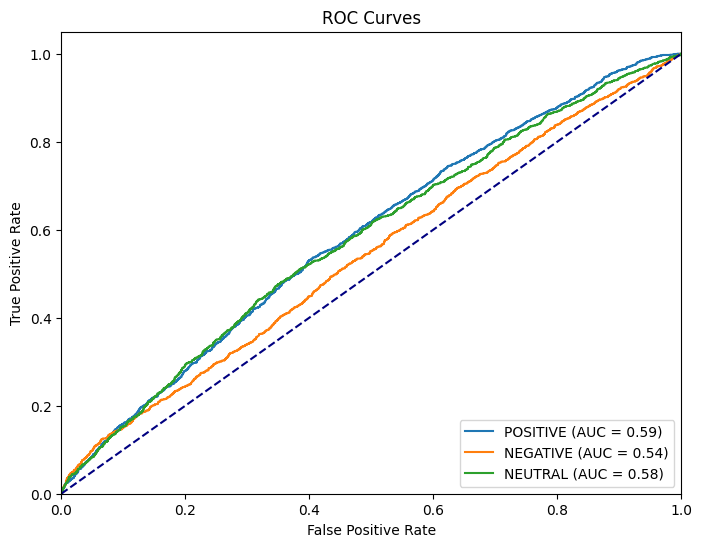

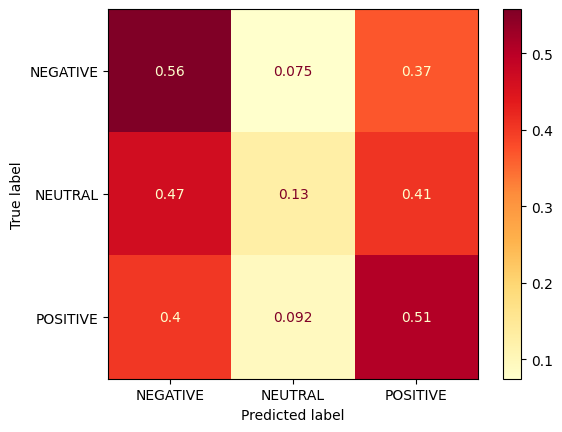

In [28]:
# This is my final model:
# The cell type is LSTM
# The hidden size is 16
# The RNN layers are 3
# The dimensions of the linear layers are [32]
# The dropout rate is 0.3
# The clip value is 0.4
# Skip Connections method is not applied
# The learning rate is 0.0001

# initialize the model
hidden_size = 16
output_size = YtrainTensor.shape[1]
cell_type = 'LSTM'
num_layers = 3
layer_dimensions = [32]
dropout = 0.3
batch_size = 2048
timesteps = XtrainTensor_attention.shape[1]
input_size = 300
gradient_clipping = True
clip_value = 0.4
skip_connection = True
linear_layers = 1




net = Rnn_with_Attention(input_size, output_size, hidden_size, num_layers = num_layers, layer_dimensions = layer_dimensions, type = cell_type, dropout = dropout, linear_layers = linear_layers, skip_connection = skip_connection).to(compute_unit)

LR = 0.0001
optimizer = torch.optim.Adam(net.parameters(), lr=LR)
loss_func = nn.CrossEntropyLoss()

#Initialize datasets and dataloaders
TrainDataset = torch.utils.data.TensorDataset(XtrainTensor_attention, YtrainTensor) 
TrainDataloader = torch.utils.data.DataLoader(TrainDataset, batch_size = batch_size, shuffle=True) 

ValDataset = torch.utils.data.TensorDataset(XvalTensor_attention, YvalTensor) 
ValDataloader = torch.utils.data.DataLoader(ValDataset, batch_size = batch_size, shuffle=True) 

# Train the model
epochs = 100
_ = model_train(TrainDataloader, ValDataloader, net, loss_func, optimizer, compute_unit, timesteps, epochs, attention = True, gradient_clipping = gradient_clipping, clip_value = clip_value)

# plot the ROC curve and the confusion matrix
plot_roc_curve_confusion_matrix(net,XvalTensor_attention,Yval, attention = True)


In [29]:
# Predict the TestSet
with torch.no_grad():
    net.eval()
    Ytest_predict = net(XtestTensor_attention)
    
# Convert it to the right form
Ytest_predict = torch.argmax(Ytest_predict, axis=1)
Ytest_pred_initial = np.zeros(shape=(Ytest_predict.shape[0],3))
Ytest_pred_initial[np.arange(len(Ytest_predict.cpu())), Ytest_predict.cpu()] = 1
Ytest_pred_initial = encoder.inverse_transform(Ytest_pred_initial)  

submission_df = pd.DataFrame({"Id": TestSet["New_ID"], "Predicted":Ytest_pred_initial})
submission_df.to_csv('submission.csv', index=False)